In [1]:
using Printf
using DelimitedFiles
using Plots
using LinearAlgebra

## Configuration Constructor

In [2]:
struct CaseConfig 
    LX::Float64
    LY::Float64
    
    NUM_X_CELLS::Int64
    NUM_Y_CELLS::Int64
    
    NUM_RK_STEPS::Int64

    NUM_TIME_STEPS::Int64
    TIME_STEPS_SIZE::Float64
end

## Cell Constructor

In [3]:
mutable struct Cell
    C_POS::Array{Float64,1}
    W_POS::Array{Float64,1}
    E_POS::Array{Float64,1}
    N_POS::Array{Float64,1}
    S_POS::Array{Float64,1}

    C_VAL::Dict{String,Array{Float64,1}} # center value
    W_VAL::Dict{String,Array{Float64,1}} # west face value
    E_VAL::Dict{String,Array{Float64,1}} # east face value
    N_VAL::Dict{String,Array{Float64,1}} # north face value
    S_VAL::Dict{String,Array{Float64,1}} # south faec value

    W_UNINORM::Array{Float64,1}
    E_UNINORM::Array{Float64,1}
    N_UNINORM::Array{Float64,1}
    S_UNINORM::Array{Float64,1}
    
    X_SIZE::Float64
    Y_SIZE::Float64
    VOLUME::Float64

    # ===============================================================================
    # Construct function
    # ===============================================================================
    function Cell(config::CaseConfig, px::Float64, py::Float64, w_d::Float64, e_d::Float64, n_d::Float64, s_d::Float64)
        this = new()
    
            this.C_POS = [px, py]
            this.W_POS = [px-w_d, py]
            this.E_POS = [px+e_d, py]
            this.N_POS = [px, py+n_d]
            this.S_POS = [px, py-s_d]
        

            this.W_UNINORM = [-1.0, 0.0]
            this.E_UNINORM = [ 1.0, 0.0]
            this.N_UNINORM = [0.0,  1.0]
            this.S_UNINORM = [0.0, -1.0]
    
        
            this.C_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS),
                               "V" => zeros(config.NUM_RK_STEPS),
                               "P" => zeros(config.NUM_RK_STEPS) )
    
            this.W_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS),
                               "V" => zeros(config.NUM_RK_STEPS),
                               "P" => zeros(config.NUM_RK_STEPS) )
    
            this.E_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS),
                               "V" => zeros(config.NUM_RK_STEPS),
                               "P" => zeros(config.NUM_RK_STEPS) )
    
            this.N_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS),
                               "V" => zeros(config.NUM_RK_STEPS),
                               "P" => zeros(config.NUM_RK_STEPS) )
    
            this.S_VAL = Dict( "U" => zeros(config.NUM_RK_STEPS),
                               "V" => zeros(config.NUM_RK_STEPS),
                               "P" => zeros(config.NUM_RK_STEPS) )
            
            this.X_SIZE = w_d + e_d
            this.Y_SIZE = n_d + s_d
            this.VOLUME = this.X_SIZE*this.Y_SIZE
    
        return this
    end
end

## Mesh Constructor

In [172]:
mutable struct RecMesh2D
    P_CELL::Array{Cell,2}
    U_CELL::Array{Cell,2}
    V_CELL::Array{Cell,2}
    
    # ===============================================================================
    # Construct function
    # ===============================================================================
    function RecMesh2D(config::CaseConfig)
        this = new()
        
        node_x = map(x->compute_streching(x,x)*config.LX, range(0, 1, length=config.NUM_X_CELLS+1))
        node_y = map(x->compute_streching(x,x)*config.LY, range(0, 1, length=config.NUM_Y_CELLS+1))

        push!(node_x, node_x[end]+(node_x[end]-node_x[end-1]))
        pushfirst!(node_x, node_x[1]-(node_x[2]-node_x[1]))
    
        push!(node_y, node_y[end]+(node_y[end]-node_y[end-1]))
        pushfirst!(node_y, node_y[1]-(node_y[2]-node_y[1]))

        
        this.P_CELL = [ Cell(config, 0.5*(node_x[i]+node_x[i+1]),
                                     0.5*(node_y[j]+node_y[j+1]), 
                                     0.5*(node_x[i]+node_x[i+1])-node_x[i],
                                     node_x[i+1]-0.5*(node_x[i]+node_x[i+1]),
                                     node_y[j+1]-0.5*(node_y[j]+node_y[j+1]),
                                     0.5*(node_y[j]+node_y[j+1])-node_y[j])
            
                        for i = 1 : config.NUM_X_CELLS+2,
                            j = 1 : config.NUM_Y_CELLS+2 ]
        
        
        
        this.U_CELL = [ Cell(config, node_x[i+1],
                                     0.5*(node_y[j]+node_y[j+1]),
                                     node_x[i+1] - 0.5*(node_x[i]+node_x[i+1]),
                                     0.5*(node_x[i+1]+node_x[i+2]) - node_x[i+1],
                                     node_y[j+1]-0.5*(node_y[j]+node_y[j+1]),
                                     0.5*(node_y[j]+node_y[j+1])-node_y[j])
            
                        for i = 1 : config.NUM_X_CELLS+1,
                            j = 1 : config.NUM_Y_CELLS+2 ]    

        
        this.V_CELL = [ Cell(config, 0.5*(node_x[i]+node_x[i+1]),
                                     node_y[j+1],
                                     0.5*(node_x[i]+node_x[i+1])-node_x[i],
                                     node_x[i+1]-0.5*(node_x[i]+node_x[i+1]),
                                     0.5*(node_y[j+1]+node_y[j+2]) - node_y[j+1],
                                     node_y[j+1] - 0.5*(node_y[j]+node_y[j+1]))
            
                        for i = 1 : config.NUM_X_CELLS+2,
                            j = 1 : config.NUM_Y_CELLS+1 ]
        

        return this
    end


    # ===============================================================================
    # Compute Strech fun by Newton method
    # ===============================================================================
    function compute_streching(x0::Float64, xn::Float64, K::Float64 =1.5, Beta::Float64 = 0.5,
                               e::Float64 = 0.001, iter_max::Int64 = 50)

        x_a = x0

        subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
        subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

        x_b = x_a-subs/subs_x
        iter_num=1

        while abs(x_a-x_b)>e
            iter_num = iter_num+1
            x_a = x_b
            subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
            subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

            x_b = x_a-subs/subs_x

            if iter_num>=iter_max
                return x_b
            end
        end

        return x_b
    end
    
end

## Interpolation Function

In [173]:
function re_linear_interpolate(target_pos, target_str, target_val, cell_1, cell_2, rk_step)
    
    len_1 = LinearAlgebra.norm(cell_1.C_POS - target_pos)
    len_2 = LinearAlgebra.norm(cell_2.C_POS - target_pos)

    total_len =  len_1 + len_2
     
    return ( (target_val * total_len) - len_1*cell_2.C_VAL[target_str][rk_step] ) / len_2
    
end

function linear_interpolate(target_pos, target_str, cell_1, cell_2, rk_step)
    
    len_1 = LinearAlgebra.norm(cell_1.C_POS - target_pos)
    len_2 = LinearAlgebra.norm(cell_2.C_POS - target_pos)

    total_len =  len_1 + len_2
 
    return ( len_1*cell_2.C_VAL[target_str][rk_step] + len_2*cell_1.C_VAL[target_str][rk_step] ) / total_len
    
end


function bilinear_interpolate(target_pos, target_str, cell_1, cell_2, cell_3, cell_4, rk_step)
    
        #https://en.wikipedia.org/wiki/Bilinear_interpolation
    
        area_1 = abs(prod(cell_1.C_POS - target_pos))
        area_2 = abs(prod(cell_2.C_POS - target_pos))
        area_3 = abs(prod(cell_3.C_POS - target_pos))
        area_4 = abs(prod(cell_4.C_POS - target_pos))
    
        total_area = area_1 + area_2 + area_3 + area_4
    
        return ( area_1*cell_3.C_VAL[target_str][rk_step] + area_2*cell_4.C_VAL[target_str][rk_step] + 
                 area_3*cell_1.C_VAL[target_str][rk_step] + area_4*cell_2.C_VAL[target_str][rk_step] ) / total_area
    
end


function cal_interplation_val(myconfig::CaseConfig, mymesh::RecMesh2D)
    
    for rk_step = 1 : myconfig.NUM_RK_STEPS
        
        # CELL_P ===========================================
        for i = 2 : size(mymesh.P_CELL,1)-1
            for j = 2 : size(mymesh.P_CELL,2)-1

                mymesh.P_CELL[i,j].W_VAL["P"][rk_step] = linear_interpolate(mymesh.P_CELL[i,j].W_POS, "P", mymesh.P_CELL[i-1,j], mymesh.P_CELL[i,j], rk_step)
                mymesh.P_CELL[i,j].W_VAL["U"][rk_step] = mymesh.U_CELL[i-1,j].C_VAL["U"][rk_step]
                mymesh.P_CELL[i,j].W_VAL["V"][rk_step] = bilinear_interpolate(mymesh.P_CELL[i,j].W_POS, "V", mymesh.V_CELL[i-1,j], mymesh.V_CELL[i,j], mymesh.V_CELL[i,j-1], mymesh.V_CELL[i-1,j-1], rk_step)
                
                
                mymesh.P_CELL[i,j].E_VAL["P"][rk_step] = linear_interpolate(mymesh.P_CELL[i,j].E_POS, "P", mymesh.P_CELL[i+1,j], mymesh.P_CELL[i,j], rk_step)
                mymesh.P_CELL[i,j].E_VAL["U"][rk_step] = mymesh.U_CELL[i,j].C_VAL["U"][rk_step]
                mymesh.P_CELL[i,j].E_VAL["V"][rk_step] = bilinear_interpolate(mymesh.P_CELL[i,j].E_POS, "V", mymesh.V_CELL[i,j], mymesh.V_CELL[i+1,j], mymesh.V_CELL[i+1,j-1], mymesh.V_CELL[i,j-1], rk_step)
                
                
                mymesh.P_CELL[i,j].N_VAL["P"][rk_step] = linear_interpolate(mymesh.P_CELL[i,j].N_POS, "P", mymesh.P_CELL[i,j+1], mymesh.P_CELL[i,j], rk_step)
                mymesh.P_CELL[i,j].N_VAL["U"][rk_step] = bilinear_interpolate(mymesh.P_CELL[i,j].N_POS, "U", mymesh.U_CELL[i-1,j+1], mymesh.U_CELL[i,j+1], mymesh.U_CELL[i,j], mymesh.U_CELL[i-1,j], rk_step)
                mymesh.P_CELL[i,j].N_VAL["V"][rk_step] = mymesh.V_CELL[i,j].C_VAL["V"][rk_step]  
                
                
                mymesh.P_CELL[i,j].S_VAL["P"][rk_step] = linear_interpolate(mymesh.P_CELL[i,j].S_POS, "P", mymesh.P_CELL[i,j-1], mymesh.P_CELL[i,j], rk_step)
                mymesh.P_CELL[i,j].S_VAL["U"][rk_step] = bilinear_interpolate(mymesh.P_CELL[i,j].S_POS, "U", mymesh.U_CELL[i-1,j], mymesh.U_CELL[i,j], mymesh.U_CELL[i,j-1], mymesh.U_CELL[i-1,j-1], rk_step)
                mymesh.P_CELL[i,j].S_VAL["V"][rk_step] = mymesh.V_CELL[i,j-1].C_VAL["V"][rk_step]  

                
                mymesh.P_CELL[i,j].C_VAL["U"][rk_step] = linear_interpolate(mymesh.P_CELL[i,j].C_POS, "U", mymesh.U_CELL[i-1,j], mymesh.U_CELL[i,j], rk_step)
                mymesh.P_CELL[i,j].C_VAL["V"][rk_step] = linear_interpolate(mymesh.P_CELL[i,j].C_POS, "V", mymesh.V_CELL[i,j-1], mymesh.V_CELL[i,j], rk_step)
                
            end
        end
        
        # CELL_U ===========================================
        for i = 1 : size(mymesh.U_CELL,1)
            for j = 2 : size(mymesh.U_CELL,2)-1

                mymesh.U_CELL[i,j].W_VAL["P"][rk_step] = mymesh.P_CELL[i,j].C_VAL["P"][rk_step]
                if i != 1
                    mymesh.U_CELL[i,j].W_VAL["U"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].W_POS, "U", mymesh.U_CELL[i-1,j], mymesh.U_CELL[i,j], rk_step)
                end
                mymesh.U_CELL[i,j].W_VAL["V"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].W_POS, "V", mymesh.V_CELL[i,j], mymesh.V_CELL[i,j-1], rk_step)

                
                mymesh.U_CELL[i,j].E_VAL["P"][rk_step] = mymesh.P_CELL[i+1,j].C_VAL["P"][rk_step]
                if i != size(mymesh.U_CELL,1)
                    mymesh.U_CELL[i,j].E_VAL["U"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].E_POS, "U", mymesh.U_CELL[i+1,j], mymesh.U_CELL[i,j], rk_step)
                end
                mymesh.U_CELL[i,j].E_VAL["V"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].E_POS, "V", mymesh.V_CELL[i+1,j], mymesh.V_CELL[i+1,j-1], rk_step)
                
                
                mymesh.U_CELL[i,j].N_VAL["P"][rk_step] = bilinear_interpolate(mymesh.U_CELL[i,j].N_POS, "P", mymesh.P_CELL[i,j+1], mymesh.P_CELL[i+1,j+1], mymesh.P_CELL[i+1,j], mymesh.P_CELL[i,j], rk_step)
                mymesh.U_CELL[i,j].N_VAL["U"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].N_POS, "U", mymesh.U_CELL[i,j+1], mymesh.U_CELL[i,j], rk_step)
                mymesh.U_CELL[i,j].N_VAL["V"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].N_POS, "V", mymesh.V_CELL[i,j], mymesh.V_CELL[i+1,j], rk_step)
                
                mymesh.U_CELL[i,j].S_VAL["P"][rk_step] = bilinear_interpolate(mymesh.U_CELL[i,j].S_POS, "P", mymesh.P_CELL[i,j], mymesh.P_CELL[i+1,j], mymesh.P_CELL[i+1,j-1], mymesh.P_CELL[i,j-1], rk_step)
                mymesh.U_CELL[i,j].S_VAL["U"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].S_POS, "U", mymesh.U_CELL[i,j-1], mymesh.U_CELL[i,j], rk_step)
                mymesh.U_CELL[i,j].S_VAL["V"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].S_POS, "V", mymesh.V_CELL[i,j-1], mymesh.V_CELL[i+1,j-1], rk_step)

                mymesh.U_CELL[i,j].C_VAL["P"][rk_step] = linear_interpolate(mymesh.U_CELL[i,j].C_POS, "P", mymesh.P_CELL[i+1,j], mymesh.P_CELL[i,j], rk_step)
                mymesh.U_CELL[i,j].C_VAL["V"][rk_step] = bilinear_interpolate(mymesh.U_CELL[i,j].C_POS, "V", mymesh.V_CELL[i,j], mymesh.V_CELL[i+1,j], mymesh.V_CELL[i+1,j-1], mymesh.V_CELL[i,j-1], rk_step)
                
            end
        end
        
        # CELL_V ===========================================
        for i = 2 : size(mymesh.V_CELL,1)-1
            for j = 1 : size(mymesh.V_CELL,2)

                mymesh.V_CELL[i,j].W_VAL["P"][rk_step] = bilinear_interpolate(mymesh.V_CELL[i,j].W_POS, "P", mymesh.P_CELL[i-1,j+1], mymesh.P_CELL[i,j+1], mymesh.P_CELL[i,j], mymesh.P_CELL[i-1,j], rk_step)
                mymesh.V_CELL[i,j].W_VAL["U"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].W_POS, "U", mymesh.U_CELL[i-1,j+1], mymesh.U_CELL[i-1,j], rk_step)
                mymesh.V_CELL[i,j].W_VAL["V"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].W_POS, "V", mymesh.V_CELL[i,j], mymesh.V_CELL[i-1,j], rk_step)
                
                
                mymesh.V_CELL[i,j].E_VAL["P"][rk_step] = bilinear_interpolate(mymesh.V_CELL[i,j].E_POS, "P", mymesh.P_CELL[i,j+1], mymesh.P_CELL[i+1,j+1], mymesh.P_CELL[i+1,j], mymesh.P_CELL[i,j], rk_step)
                mymesh.V_CELL[i,j].E_VAL["U"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].E_POS, "U", mymesh.U_CELL[i,j+1], mymesh.U_CELL[i,j], rk_step)
                mymesh.V_CELL[i,j].E_VAL["V"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].E_POS, "V", mymesh.V_CELL[i+1,j], mymesh.V_CELL[i,j], rk_step)
                
                
                mymesh.V_CELL[i,j].N_VAL["P"][rk_step] = mymesh.P_CELL[i,j+1].C_VAL["P"][rk_step]
                mymesh.V_CELL[i,j].N_VAL["U"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].N_POS, "U", mymesh.U_CELL[i-1,j+1], mymesh.U_CELL[i,j+1], rk_step)
                if j != size(mymesh.V_CELL,2)
                    mymesh.V_CELL[i,j].N_VAL["V"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].N_POS, "V", mymesh.V_CELL[i,j+1], mymesh.V_CELL[i,j], rk_step)
                end

                mymesh.V_CELL[i,j].S_VAL["P"][rk_step] = mymesh.P_CELL[i,j].C_VAL["P"][rk_step]
                mymesh.V_CELL[i,j].S_VAL["U"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].S_POS, "U", mymesh.U_CELL[i-1,j], mymesh.U_CELL[i,j], rk_step)  
                if j != 1
                    mymesh.V_CELL[i,j].S_VAL["V"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].S_POS, "V", mymesh.V_CELL[i,j], mymesh.V_CELL[i,j-1], rk_step)
                end
                
                mymesh.V_CELL[i,j].C_VAL["P"][rk_step] = linear_interpolate(mymesh.V_CELL[i,j].C_POS, "P", mymesh.P_CELL[i,j], mymesh.P_CELL[i,j+1], rk_step)
                mymesh.V_CELL[i,j].C_VAL["U"][rk_step] = bilinear_interpolate(mymesh.V_CELL[i,j].C_POS, "U", mymesh.U_CELL[i-1,j+1], mymesh.U_CELL[i,j+1], mymesh.U_CELL[i,j], mymesh.U_CELL[i-1,j], rk_step)
                
            end
        end
        
    end
end

cal_interplation_val (generic function with 1 method)

## Adection Operation

In [174]:
function advection_op(mymesh::RecMesh2D)

    rk_step = 1

    tmp_u = zeros(Float64, size(mymesh.U_CELL,1), size(mymesh.U_CELL,2))
    tmp_v = zeros(Float64, size(mymesh.V_CELL,1), size(mymesh.V_CELL,2))
    rho = ones(Float64, size(mymesh.P_CELL,1), size(mymesh.P_CELL,2))

    for i = 2 : size(mymesh.U_CELL,1)-1
        for j = 2 : size(mymesh.U_CELL,2)-1

            AD_u = ( ( mymesh.U_CELL[i,j].E_VAL["U"][rk_step]^2 - mymesh.U_CELL[i,j].W_VAL["U"][rk_step]^2 )*mymesh.U_CELL[i,j].Y_SIZE +
                   ( mymesh.U_CELL[i,j].N_VAL["U"][rk_step]*mymesh.U_CELL[i,j].N_VAL["V"][rk_step] - 
                     mymesh.U_CELL[i,j].S_VAL["U"][rk_step]*mymesh.U_CELL[i,j].S_VAL["V"][rk_step])*mymesh.U_CELL[i,j].X_SIZE )/ mymesh.U_CELL[i,j].VOLUME

            DF_u =  1/mymesh.U_CELL[i,j].VOLUME* (
                  ( (mymesh.U_CELL[i+1,j].C_VAL["U"][rk_step] - mymesh.U_CELL[i,j].C_VAL["U"][rk_step]) / LinearAlgebra.norm(mymesh.U_CELL[i+1,j].C_POS - mymesh.U_CELL[i,j].C_POS) - 
                    (mymesh.U_CELL[i,j].C_VAL["U"][rk_step] - mymesh.U_CELL[i-1,j].C_VAL["U"][rk_step]) / LinearAlgebra.norm(mymesh.U_CELL[i,j].C_POS - mymesh.U_CELL[i-1,j].C_POS)    ) * mymesh.U_CELL[i,j].Y_SIZE +  
                  ( (mymesh.U_CELL[i,j+1].C_VAL["U"][rk_step] - mymesh.U_CELL[i,j].C_VAL["U"][rk_step]) / LinearAlgebra.norm(mymesh.U_CELL[i,j+1].C_POS - mymesh.U_CELL[i,j].C_POS) - 
                    (mymesh.U_CELL[i,j].C_VAL["U"][rk_step] - mymesh.U_CELL[i,j-1].C_VAL["U"][rk_step]) / LinearAlgebra.norm(mymesh.U_CELL[i,j].C_POS - mymesh.U_CELL[i,j-1].C_POS)    ) * mymesh.U_CELL[i,j].X_SIZE 
                 )

            tmp_u[i,j] = mymesh.U_CELL[i,j].C_VAL["U"][rk_step] + myconfig.TIME_STEPS_SIZE*(-AD_u + 1/(0.5*(rho[i,j]+rho[i+1,j]))*DF_u)
        end
    end


    for i = 2 : size(mymesh.V_CELL,1)-1
        for j = 2 : size(mymesh.V_CELL,2)-1

            AD_v = ( ( mymesh.V_CELL[i,j].E_VAL["U"][rk_step]*mymesh.V_CELL[i,j].E_VAL["V"][rk_step] - 
                       mymesh.V_CELL[i,j].W_VAL["U"][rk_step]*mymesh.V_CELL[i,j].W_VAL["V"][rk_step] )*mymesh.V_CELL[i,j].Y_SIZE +
                     ( mymesh.V_CELL[i,j].N_VAL["V"][rk_step]^2 - mymesh.V_CELL[i,j].S_VAL["V"][rk_step]^2)*mymesh.V_CELL[i,j].X_SIZE )/ mymesh.V_CELL[i,j].VOLUME

            DF_v =  1/mymesh.V_CELL[i,j].VOLUME* (
                  ( (mymesh.V_CELL[i+1,j].C_VAL["V"][rk_step] - mymesh.V_CELL[i,j].C_VAL["V"][rk_step]) / LinearAlgebra.norm(mymesh.V_CELL[i+1,j].C_POS - mymesh.V_CELL[i,j].C_POS) - 
                    (mymesh.V_CELL[i,j].C_VAL["V"][rk_step] - mymesh.V_CELL[i-1,j].C_VAL["V"][rk_step]) / LinearAlgebra.norm(mymesh.V_CELL[i,j].C_POS - mymesh.V_CELL[i-1,j].C_POS)    ) * mymesh.V_CELL[i,j].Y_SIZE +  
                  ( (mymesh.V_CELL[i,j+1].C_VAL["V"][rk_step] - mymesh.V_CELL[i,j].C_VAL["V"][rk_step]) / LinearAlgebra.norm(mymesh.V_CELL[i,j+1].C_POS - mymesh.V_CELL[i,j].C_POS) - 
                    (mymesh.V_CELL[i,j].C_VAL["V"][rk_step] - mymesh.V_CELL[i,j-1].C_VAL["V"][rk_step]) / LinearAlgebra.norm(mymesh.V_CELL[i,j].C_POS - mymesh.V_CELL[i,j-1].C_POS)    ) * mymesh.V_CELL[i,j].X_SIZE 
                 )

            tmp_v[i,j] = mymesh.V_CELL[i,j].C_VAL["V"][rk_step] + myconfig.TIME_STEPS_SIZE*(-AD_v+ 1/(0.5*(rho[i,j]+rho[i,j+1]))*DF_v)
        end
    end
    
    return tmp_u, tmp_v
end

advection_op (generic function with 1 method)

## Poisson Pressure Opertation

In [175]:
function poisson_pressure_op(mymesh::RecMesh2D, tmp_u::Array{Float64,2}, tmp_v::Array{Float64,2}, 
                             maxiter::Int64 = 10, beta::Float64 = 0.95)

    tmp_coeff_1 = zeros(Float64, size(mymesh.P_CELL,1), size(mymesh.P_CELL,2))
    tmp_coeff_2 = zeros(Float64, size(mymesh.P_CELL,1), size(mymesh.P_CELL,2))
    rho = ones(Float64, size(mymesh.P_CELL,1), size(mymesh.P_CELL,2))
    
    for i = 2 : size(mymesh.P_CELL,1)-1
        for j = 2 : size(mymesh.P_CELL,2)-1

            tmp_coeff_1[i,j] = (0.5/myconfig.TIME_STEPS_SIZE)*( (tmp_u[i,j]-tmp_u[i-1,j])/mymesh.P_CELL[i,j].X_SIZE+
                                                                (tmp_v[i,j]-tmp_v[i,j-1])/mymesh.P_CELL[i,j].Y_SIZE  )


            tmp_coeff_2[i,j] = 1.0/(
                                     (1.0/mymesh.P_CELL[i,j].X_SIZE)*( 1.0/(mymesh.U_CELL[i  ,j].X_SIZE*(rho[i+1,j]+rho[i,j]) ) + 
                                                                       1.0/(mymesh.U_CELL[i-1,j].X_SIZE*(rho[i-1,j]+rho[i,j]) )) +

                                     (1.0/mymesh.P_CELL[i,j].Y_SIZE)*( 1.0/(mymesh.V_CELL[i  ,j].Y_SIZE*(rho[i,j+1]+rho[i,j]) ) + 
                                                                       1.0/(mymesh.V_CELL[i-1,j].Y_SIZE*(rho[i,j-1]+rho[i,j]) )) 
                                    )

        end
    end



    rk_step = 1
    iter = 0
    
    while true
        iter=iter+1
        for i = 2 : size(mymesh.P_CELL,1)-1
            for j = 2 : size(mymesh.P_CELL,2)-1

                mymesh.P_CELL[i,j].C_VAL["P"][rk_step] =  ( (1.0-beta)*mymesh.P_CELL[i,j].C_VAL["P"][rk_step] +
                                                             beta*tmp_coeff_2[i,j]*
                                                             (
                                                                 (1.0/mymesh.P_CELL[i,j].X_SIZE)*(mymesh.P_CELL[i+1,j].C_VAL["P"][rk_step]/ (mymesh.U_CELL[i  ,j].X_SIZE*(rho[i+1,j]+rho[i,j]) ) + 
                                                                                                  mymesh.P_CELL[i-1,j].C_VAL["P"][rk_step]/ (mymesh.U_CELL[i-1,j].X_SIZE*(rho[i-1,j]+rho[i,j]) ) ) +
                                                                 (1.0/mymesh.P_CELL[i,j].Y_SIZE)*(mymesh.P_CELL[i,j+1].C_VAL["P"][rk_step]/ (mymesh.V_CELL[i  ,j].Y_SIZE*(rho[i,j+1]+rho[i,j]) ) + 
                                                                                                  mymesh.P_CELL[i,j-1].C_VAL["P"][rk_step]/ (mymesh.V_CELL[i-1,j].Y_SIZE*(rho[i,j-1]+rho[i,j]) ) ) -                 
                                                                 tmp_coeff_1[i,j]  
                                                             )
                                                            )

            end
        end

        if iter > maxiter
            break
        end

    end               
end

poisson_pressure_op (generic function with 3 methods)

## Correct Velocity Operation

In [176]:
function correct_vel_op(mymesh::RecMesh2D, myconfig::CaseConfig, tmp_u::Array{Float64,2}, tmp_v::Array{Float64,2})
    rk_step = 1
    rho = ones(Float64, size(mymesh.P_CELL,1), size(mymesh.P_CELL,2))
    
    #CORRECT THE u-velocity
    for i = 2 : size(mymesh.U_CELL,1)-1
        for j = 2 : size(mymesh.U_CELL,2)-1

            mymesh.U_CELL[i,j].C_VAL["U"][rk_step] = ( tmp_u[i,j] - myconfig.TIME_STEPS_SIZE*(2.0 / mymesh.U_CELL[i,j].X_SIZE) *
                                                         (mymesh.P_CELL[i+1,j].C_VAL["P"][rk_step] - mymesh.P_CELL[i,j].C_VAL["P"][rk_step] ) / 
                                                         (rho[i+1,j]+rho[i,j])
                                                       )  
        end
    end

    #CORRECT THE v-velocity
    for i = 2 : size(mymesh.V_CELL,1)-1
        for j = 2 : size(mymesh.V_CELL,2)-1

            mymesh.V_CELL[i,j].C_VAL["V"][rk_step] = ( tmp_v[i,j] - myconfig.TIME_STEPS_SIZE*(2.0 / mymesh.V_CELL[i,j].Y_SIZE) *
                                                         (mymesh.P_CELL[i,j+1].C_VAL["P"][rk_step] - mymesh.P_CELL[i,j].C_VAL["P"][rk_step] ) / 
                                                         (rho[i,j+1]+rho[i,j])
                                                       )     
        end
    end

end

correct_vel_op (generic function with 1 method)

## Build model

In [190]:
myconfig = CaseConfig(1, 1, 20, 20, 1, 1000, 0.0001)
mymesh = RecMesh2D(myconfig)


for time_step = 1 : myconfig.NUM_TIME_STEPS
    

    
    for i = 1 : size(mymesh.U_CELL,1)
        mymesh.U_CELL[i,1].C_VAL["U"][1] = re_linear_interpolate(mymesh.U_CELL[i,1].N_POS, "U", 0.0, mymesh.U_CELL[i,1], mymesh.U_CELL[i,1], 1)
    end

    for i = 1 : size(mymesh.U_CELL,1)
        mymesh.U_CELL[i,end].C_VAL["U"][1] = re_linear_interpolate(mymesh.U_CELL[i,end-1].S_POS, "U", 1.0, mymesh.U_CELL[i,end], mymesh.U_CELL[i,end-1], 1)
    end

    for i = 1 : size(mymesh.V_CELL,2)
        mymesh.V_CELL[1,i].C_VAL["V"][1] = re_linear_interpolate(mymesh.V_CELL[1,i].E_POS, "V", 0.0, mymesh.V_CELL[1,i], mymesh.V_CELL[1,i], 1)
    end

    for i = 1 : size(mymesh.V_CELL,2)
        mymesh.V_CELL[end,i].C_VAL["V"][1] = re_linear_interpolate(mymesh.V_CELL[end,i].W_POS, "V", 0.0, mymesh.V_CELL[end,i], mymesh.V_CELL[end-1,i], 1)
    end
    
    cal_interplation_val(myconfig, mymesh)
    
    tmp_u, tmp_v = advection_op(mymesh)
    
    poisson_pressure_op(mymesh, tmp_u, tmp_v)
    
    correct_vel_op(mymesh, myconfig, tmp_u, tmp_v)
    
end

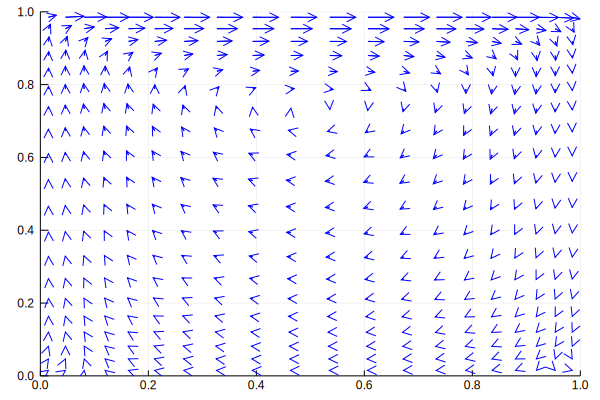

In [191]:
CELL_P_x = [ mymesh.P_CELL[i,j].C_POS[1]
                for i = 2 : size(mymesh.P_CELL,1)-1,
                    j = 2 : size(mymesh.P_CELL,2)-1]

CELL_P_y = [ mymesh.P_CELL[i,j].C_POS[2]
                for i = 2 : size(mymesh.P_CELL,1)-1,
                    j = 2 : size(mymesh.P_CELL,2)-1]

CELL_P_u = [ mymesh.P_CELL[i,j].C_VAL["U"]*0.05 
                for i = 2 : size(mymesh.P_CELL,1)-1,
                    j = 2 : size(mymesh.P_CELL,2)-1]

CELL_P_v = [ mymesh.P_CELL[i,j].C_VAL["V"]*0.05
                for i = 2 : size(mymesh.P_CELL,1)-1,
                    j = 2 : size(mymesh.P_CELL,2)-1]


quiver( collect(Iterators.flatten(CELL_P_x)), collect(Iterators.flatten(CELL_P_y)),
        quiver= ( collect(Iterators.flatten(CELL_P_u)), collect(Iterators.flatten(CELL_P_v))), c=:blue)
plot!(xlims=(0,1),ylims=(0,1))

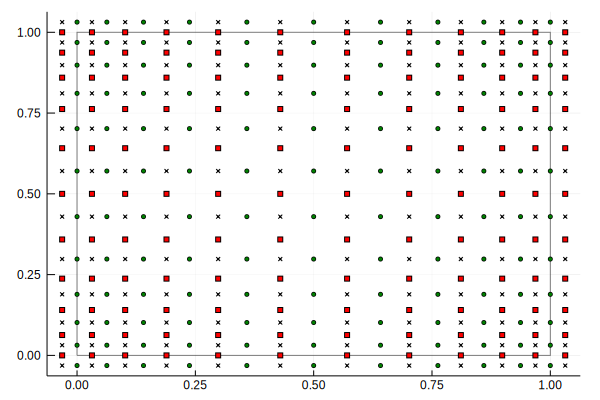

In [181]:
CELLPx = [ mymesh.P_CELL[i,j].C_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]

CELLPy = [ mymesh.P_CELL[i,j].C_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]


CELLUx = [ mymesh.U_CELL[i,j].C_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS+1,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]

CELLUy = [ mymesh.U_CELL[i,j].C_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS+1,
                    j = 1 : myconfig.NUM_Y_CELLS+2 ]


CELLVx = [ mymesh.V_CELL[i,j].C_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+1 ]

CELLVy = [ mymesh.V_CELL[i,j].C_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS+2,
                    j = 1 : myconfig.NUM_Y_CELLS+1 ]

plot(Shape( [0,1,1,0],  [0,0,1,1]), fillcolor = :white, opacity=.5)
scatter!(collect(Iterators.flatten(CELLPx)), collect(Iterators.flatten(CELLPy)), markershape = :xcross, markersize = 1, markercolor = :black, leg=false)
scatter!(collect(Iterators.flatten(CELLUx)), collect(Iterators.flatten(CELLUy)), markershape = :circle, markersize = 2, markercolor = :green, leg=false)
scatter!(collect(Iterators.flatten(CELLVx)), collect(Iterators.flatten(CELLVy)), markershape = :rect, markersize = 2, markercolor = :red, leg=false)

In [23]:
using Plots
gr(size=(600,400))

function example()
  X = range(-2, stop=2, length=100)
  Y = range(-2, stop=2, length=100)
  f(x, y) = x^3 - 3x + y^2
  contour(X, Y, f)

  x = range(-2, stop=2, length=11)
  y = range(-2, stop=2, length=11)
    
  df(x, y) = [3x^2 - 3; 2y] / 25
    
  println(typeof(df))
    
  quiver!(x, y', quiver=df, c=:blue)
    

  xlims!(-2, 2)
  ylims!(-2, 2)
  png("example")
end

example()

getfield(Main, Symbol("#df#19"))
